# Authors:
##### Maria Musiał : 156062
##### Joanna Szczublińska : 156xxx
##### Wiktoria Szarzyńska : 156xxx

In [38]:
import pandas as pd
import numpy as np
import tensorflow as tf
import os
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
from torch.utils.data import Dataset 
import torch
import torchvision.models as models
import PIL.Image
import string
import torch.optim as optim
import torch.nn.functional as F
import torch.nn as nn
from tqdm import tqdm

### Defining dataset class

In [39]:
# root_dir = "put_jetbot_dataset/dataset/"
# samples=[]


class JetBotDataset(Dataset):
    """
    Dataset that reads images and forward, left values from csv (from root_dir), uses transformations externally defined.
    Returns image(rgb), [forward, left] tensor
    """
    def __init__(self, root_dir, transform=None):
        self.samples = []
        self.transform = transform
        
        folders = [name for name in os.listdir(root_dir)
           if os.path.isdir(os.path.join(root_dir, name))]

        for folder_name in folders:
            file_name = folder_name + ".csv"
            csv_path = os.path.join(root_dir, file_name)
            folder_path = os.path.join(root_dir, folder_name)
            # print(folder_name, file_name, csv_path, folder_path)

            if not os.path.exists(csv_path):
                print(f"Warning: CSV file {csv_path} not found, skipping folder {folder_name}")
                continue
            
            try:
                df = pd.read_csv(csv_path, header=None, dtype={"0":"int32", "1":"float64", "2":"float64"})
                df.columns = ["filename", "forward", "left"]

                for _, row in df.iterrows():
                    img_path = os.path.join(folder_path, str(row['filename'])[:-2].zfill(4)+".jpg")     # row[filename gives number of photo]; zfill gives leading zeros
                    if not os.path.exists(img_path):
                        print(f"Warnign: Image file {img_path} not found.")
                        continue
                    self.samples.append((img_path, float(row["forward"]), float(row["left"])))
            except Exception as e:
                print(f"Error processing {csv_path}: e")
                
        print(f"Loaded {len(self.samples)} samples from {len(folders)} folders")

                
    def __len__(self):
        return len(self.samples)
        
    def __getitem__(self, idx):
        img_path, forward, left = self.samples[idx]
        
        try:
            image = PIL.Image.open(img_path).convert("RGB")
            if self.transform:
                image = self.transform(image)

            ## Konwersja left (ciągłe) na etykietę klasy
            if left < -0.5:
                class_idx = 0
            elif left < -0.25:
                class_idx = 1
            elif left <= 0.25:
                class_idx = 2
            elif left <= 0.5:
                class_idx = 3
            else:
                class_idx = 4

            return image, (torch.tensor(forward, dtype=torch.float32), torch.tensor(class_idx, dtype=torch.long))




            # return image, torch.tensor([forward, left], dtype=torch.float32)    

        except Exception as e:
            print(f"Error loading image {img_path}: {e}")
            placeholder = torch.zeros((3,224,224))
            return placeholder, torch.tensor([0.0, 0.0], dtype=torch.float32)
    
    
def get_transforms(augument=True):
    """Create transformations for training and validation"""
    common_transforms = [
        transforms.Resize((224,224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ]
    if augument:
        # Transformations: resize to 224x224, color jitter, normalize for rgb values predefined using imagenet 
        train_transforms = [
            transforms.ColorJitter(0.3, 0.3, 0.3, 0.3),  #color transofmrations
            transforms.RandomRotation(10),
            *common_transforms
        ]  
        return transforms.Compose(train_transforms)
    else:
        return transforms.Compose(common_transforms)

In [40]:
from collections import defaultdict
import matplotlib.pyplot as plt

def plot_samples_per_folder(dataset):
    folder_counts = defaultdict(int)
    for img_path, _, _ in dataset.samples:
        folder = os.path.basename(os.path.dirname(img_path))
        folder_counts[folder] += 1
    
    folders = list(folder_counts.keys())
    counts = [folder_counts[f] for f in folders]
    
    plt.figure(figsize=(12, 6))
    plt.bar(folders, counts)
    plt.xticks(rotation=45, ha='right')
    plt.title("Samples per Folder")
    plt.ylabel("Number of Samples")
    plt.tight_layout()
    plt.show()


def show_sample_images(dataset, num=9):
    indices = np.random.choice(len(dataset), num, replace=False)
    plt.figure(figsize=(12, 12))
    
    for i, idx in enumerate(indices):
        img, (fwd, left) = dataset[idx]
        img = img.permute(1, 2, 0).numpy()
        img = img * np.array([0.229, 0.224, 0.225]) + np.array([0.485, 0.456, 0.406])  # Unnormalize
        img = np.clip(img, 0, 1)
        
        plt.subplot(3, 3, i + 1)
        plt.imshow(img)
        plt.title(f"Fwd: {fwd:.2f}, Left: {left:.2f}")
        plt.axis("off")
    
    plt.tight_layout()
    plt.show()

def plot_target_distributions(dataset):
    forward_vals = [s[1] for s in dataset.samples]
    left_vals = [s[2] for s in dataset.samples]

    plt.figure(figsize=(12, 4))

    plt.subplot(1, 3, 1)
    plt.hist(forward_vals, bins=50, color='skyblue')
    plt.title("Forward Distribution")
    plt.xlabel("Forward")
    
    plt.subplot(1, 3, 2)
    plt.hist(left_vals, bins=50, color='salmon')
    plt.title("Left Distribution")
    plt.xlabel("Left")

    plt.subplot(1, 3, 3)
    plt.scatter(forward_vals, left_vals, alpha=0.3, s=5)
    plt.title("Forward vs Left")
    plt.xlabel("Forward")
    plt.ylabel("Left")

    plt.tight_layout()
    plt.show()



Warnign: Image file dataset/1652876206.2541456\0008.jpg not found.
Warnign: Image file dataset/1652876206.2541456\0009.jpg not found.
Warnign: Image file dataset/1652876206.2541456\0010.jpg not found.
Warnign: Image file dataset/1652876206.2541456\0011.jpg not found.
Warnign: Image file dataset/1652876206.2541456\0012.jpg not found.
Warnign: Image file dataset/1652876206.2541456\0013.jpg not found.
Warnign: Image file dataset/1652876206.2541456\0014.jpg not found.
Warnign: Image file dataset/1652876206.2541456\0015.jpg not found.
Warnign: Image file dataset/1652876206.2541456\0019.jpg not found.
Warnign: Image file dataset/1652876206.2541456\0020.jpg not found.
Warnign: Image file dataset/1652876206.2541456\0021.jpg not found.
Warnign: Image file dataset/1652876206.2541456\0022.jpg not found.
Warnign: Image file dataset/1652876206.2541456\0023.jpg not found.
Warnign: Image file dataset/1652876206.2541456\0024.jpg not found.
Warnign: Image file dataset/1652876206.2541456\0025.jpg not fo

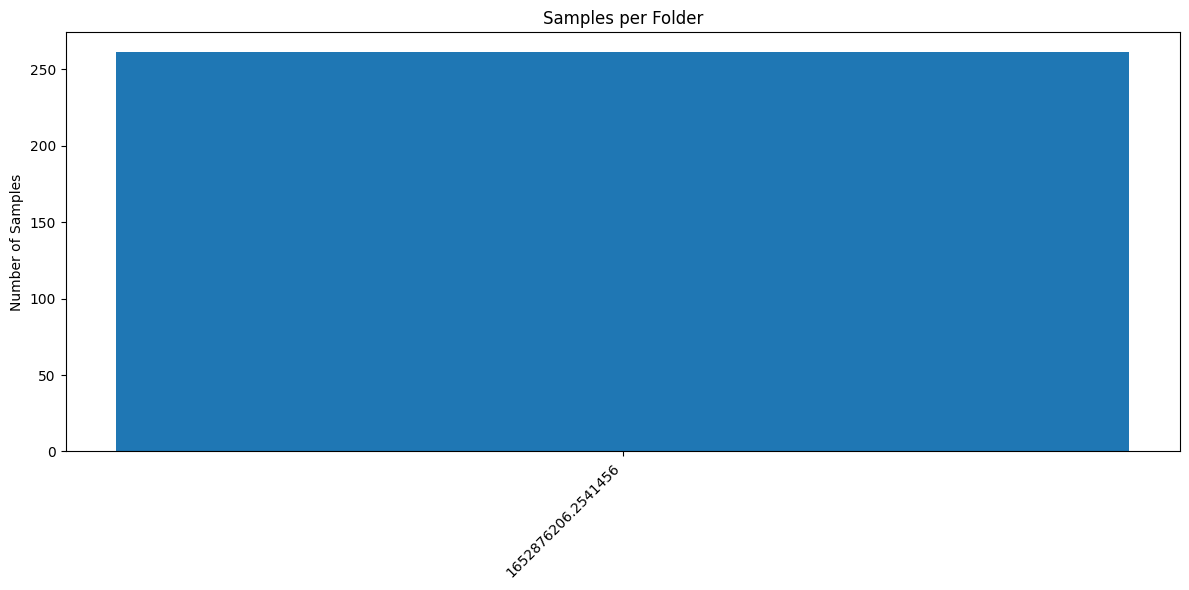

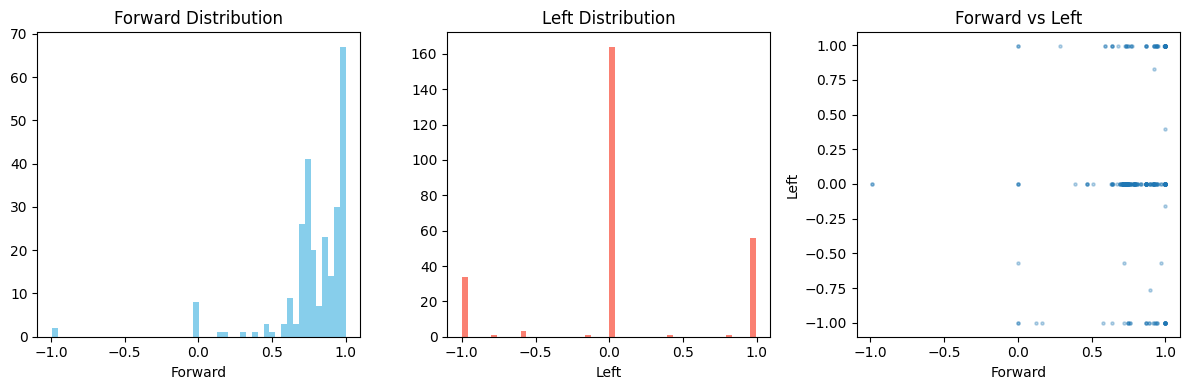

AttributeError: 'Image' object has no attribute 'permute'

<Figure size 1200x1200 with 0 Axes>

In [41]:
train_dataset = JetBotDataset(root_dir="dataset/", transform=None)

plot_samples_per_folder(train_dataset)
plot_target_distributions(train_dataset)
show_sample_images(train_dataset, num=9)


### Dividing dataset to train, test, validation

In [42]:
from torch.utils.data import random_split, DataLoader

def create_datasets(root_dir, train_ratio=0.7, val_ratio=0.15, test_ratio=0.15, batch_size=32):
    assert abs(train_ratio + val_ratio + test_ratio - 1.0) < 1e-6, "Ratios must sum to 1"

    # Get transforms
    train_transform = get_transforms(augument=True)
    val_test_transform = get_transforms(augument=False)

    # Load full dataset with dummy transform (we'll override it in subsets)
    full_dataset = JetBotDataset(root_dir, transform=None)
    total_size = len(full_dataset)

    # Compute lengths
    train_len = int(total_size * train_ratio)
    val_len = int(total_size * val_ratio)
    test_len = total_size - train_len - val_len

    # Split dataset
    train_set, val_set, test_set = random_split(full_dataset, [train_len, val_len, test_len])

    # Assign transforms manually (they use the same dataset class)
    train_set.dataset.transform = train_transform
    val_set.dataset.transform = val_test_transform
    test_set.dataset.transform = val_test_transform

    # Optionally return DataLoaders
    return {
        "train": DataLoader(train_set, batch_size=batch_size, shuffle=True),
        "val": DataLoader(val_set, batch_size=batch_size),
        "test": DataLoader(test_set, batch_size=batch_size)
    }


### Divide to train and test

In [43]:
# from torch.utils.data import random_split

# generator = torch.Generator().manual_seed(44)
# num_test = int(len(dataset) * 0.2)
# train_dataset, test_dataset = random_split(dataset, [len(dataset) - num_test, num_test], generator= generator)

# train_loader = DataLoader(train_dataset, batch_size=8, shuffle=False)
# test_loader = DataLoader(test_dataset, batch_size=8, shuffle=False)

In [44]:
# data = create_datasets(root_dir = "put_jetbot_dataset/dataset/", batch_size=8)
# train_loader = data["train"]
# val_loader = data["val"]
# test_loader = data["test"]


## Displaying dataset

In [45]:
import matplotlib.pyplot as plt
import numpy as np
import torchvision
import torch

# Function to unnormalize using ImageNet stats
def unnormalize(img):
    mean = torch.tensor([0.485, 0.456, 0.406]).view(3, 1, 1)
    std = torch.tensor([0.229, 0.224, 0.225]).view(3, 1, 1)
    return img * std + mean

# Show a batch of images from DataLoader
def show_batch(data_loader):
    dataiter = iter(data_loader)
    images, labels = next(dataiter)

    # Unnormalize all images in the batch
    unnorm_images = unnormalize(images.clone())

    # Create a grid and display
    img_grid = torchvision.utils.make_grid(unnorm_images, nrow=5)
    npimg = img_grid.permute(1, 2, 0).numpy()
    npimg = np.clip(npimg, 0, 1)

    plt.figure(figsize=(15, 5))
    plt.imshow(npimg)
    plt.axis("off")

    # Show the [forward, left] labels
    print("Labels (forward, left):")
    for i in range(min(5, labels.size(0))):  # show up to 5 labels
        print(f"{i+1}. {labels[i].tolist()}")

# dataiter = iter(train_loader)
# images, labels = next(dataiter)
# print(images[0], labels[0])
# # Example usage (assuming train_loader exists)
# show_batch(train_loader)


### Resnet transfer learning

In [46]:
# model = models.resnet18(pretrained=True)
# model.fc = torch.nn.Linear(512,2)
# for param in model.parameters():
#     param.requires_grad = False

# for param in model.fc.parameters():
#     param.requires_grad = True
# device = torch.device('cpu')
# model = model.to(device)

### Train model to 2 output: forward, left
> Horrible, training takes too long, we're ditching this approach

In [47]:
# import torch.nn.functional as functional
# import torch.optim as optim


# epochs = 70
# best_model_path = 'best_model_jetbot.pth'
# best_loss = 1e9
# optimizer = optim.Adam(model.parameters())

# for epoch in range(epochs):
#     model.train()
#     train_loss = 0.0
    
#     for images, targets in iter(train_loader):
#         images = images.to(device)
#         targets = targets.to(device)
#         optimizer.zero_grad()
#         outputs = model(images)
#         loss = functional.mse_loss(outputs, targets)
#         train_loss += float(loss)
#         loss.backward()
#         optimizer.step()
#     train_loss /= len(train_loader)
    
#     model.eval()
#     test_loss = 0.0
#     with torch.no_grad():
#         for images, targets in iter(test_loader):
#             images = images.to(device)
#             targets = targets.to(device)
#             outputs = model(images)
#             loss = functional.mse_loss(outputs, targets)      
#             test_loss += float(loss)
#     test_loss /= len(test_loader)
        
#     print(f"Train: {train_loss} -- Test: {test_loss}")
#     if test_loss < best_loss:
#         torch.save(model.state_dict(), best_model_path)
#         best_loss = test_loss
        

###  Nvidia paper CNN


In [ ]:
class NvidiaPaperNetwork(nn.Module):
    """implementation of nvidia's end-to-end self driving cars network"""
    def __init__(self):
        super(NvidiaPaperNetwork, self).__init__()
        
        self.conv1a = nn.Conv2d(3, 12, kernel_size=3, stride=2, padding=1)
        self.conv1b = nn.Conv2d(12, 12, kernel_size=3, stride=1, padding=1)
        
        self.conv2a = nn.Conv2d(12, 18, kernel_size=3, stride=2, padding=1)
        self.conv2b = nn.Conv2d(18, 18, kernel_size=3, stride=1, padding=1)
        
        self.conv3a = nn.Conv2d(18, 24, kernel_size=3, stride=2, padding=1)
        self.conv3b = nn.Conv2d(24, 24, kernel_size=3, stride=1, padding=1)
        
        self.conv4 = nn.Conv2d(24, 32, kernel_size=3, stride=2, padding=1)
        self.conv5 = nn.Conv2d(32, 32, kernel_size=3, stride=1, padding=1)
        
        # 224 -> 112 -> 56 -> 28 -> 14 -> 14 after all conv layers
        feature_size = 32 *14*14  #32 channels of 28x28
        self.fc1 = nn.Linear(feature_size, 64)
        self.fc2 = nn.Linear(64, 32)
        self.fc3 = nn.Linear(32, 10)
        
        self.output = nn.Linear(10, 6)  # Output of 2 values: forward, left
        
    def forward(self, x):
        
        x = F.relu(self.conv1a(x))
        x = F.relu(self.conv1b(x))
        
        x = F.relu(self.conv2a(x))
        x = F.relu(self.conv2b(x))
        
        x = F.relu(self.conv3a(x))
        x = F.relu(self.conv3b(x))
        
        x = F.relu(self.conv4(x))
        x = F.relu(self.conv5(x))
        
        x = x.view(x.size(0), -1)  #Flatten the output 
    
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        
        x = self.output(x)
        
        return x
    

In [55]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")
model = NvidiaPaperNetwork().to(device)

Using device: cpu


In [56]:
print("\nModel architecture:")
print(model)

# Count number of parameters
total_params = sum(p.numel() for p in model.parameters())
print(f"\nTotal parameters: {total_params:,}")



Model architecture:
NvidiaPaperNetwork(
  (conv1a): Conv2d(3, 12, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (conv1b): Conv2d(12, 12, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2a): Conv2d(12, 18, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (conv2b): Conv2d(18, 18, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3a): Conv2d(18, 24, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (conv3b): Conv2d(24, 24, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv4): Conv2d(24, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (conv5): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (fc1): Linear(in_features=6272, out_features=64, bias=True)
  (fc2): Linear(in_features=64, out_features=32, bias=True)
  (fc3): Linear(in_features=32, out_features=10, bias=True)
  (output): Linear(in_features=10, out_features=6, bias=True)
)

Total parameters: 435,800


In [77]:
def training(model, train_loader, val_loader, device, epochs=70):
    """
    Training loop with model saving
    """
    best_model_path = 'best_model_jetbot.pth'
    best_loss = 1e9
    patience = 7
    patience_counter = 0    
    
    optimizer = optim.Adam(model.parameters(), lr =0.0003, weight_decay=1e-5)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', factor=0.5, patience=5)
    class_weights = torch.tensor([1.5, 1.0, 0.5, 1.0, 1.5], dtype=torch.float32).to(device)

    
    train_loss_history = []
    val_loss_history = []

    for epoch in range(epochs):
        if patience_counter >= patience:
            print(f"Early stopping triggered at epoch {epoch+1}.")
            break
        
        model.train()
        train_loss = 0.0
        
        train_iterator = tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs} [Train]")

        for images, targets in train_iterator:
            images = images.to(device)
            
            forward, left_classes = targets
            forward_target = forward.to(device)
            left_target = left_classes.to(device)
            
            optimizer.zero_grad()
            
            outputs = model(images)
            forward_pred = outputs[:, 0]         # regresja
            left_logits = outputs[:, 1:]         # klasyfikacja (logity dla 5 klas)


            loss_reg = F.mse_loss(forward_pred, forward_target)
            loss_cls = F.cross_entropy(left_logits, left_target, weight=class_weights)

            train_loss = loss_reg + loss_cls
            
            train_loss.backward()
            
            # Gradient clipping to prevent exploding gradients
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            optimizer.step()
            train_iterator.set_postfix(loss=float(train_loss))
            
        train_loss /= len(train_loader)
        train_loss_history.append(train_loss)
        
        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            val_iterator = tqdm(val_loader, desc=f"Epoch {epoch+1}/{epochs} [Test]")
            for images, targets in val_iterator:
                images = images.to(device)
                
                forward, left_classes = targets
                forward_target = forward.to(device)
                left_target = left_classes.to(device)
                
                optimizer.zero_grad()
                
                outputs = model(images)
                forward_pred = outputs[:, 0]         # regresja
                left_logits = outputs[:, 1:]         # klasyfikacja (logity dla 5 klas)


                loss_reg = F.mse_loss(forward_pred, forward_target)
                loss_cls = F.cross_entropy(left_logits, left_target, weight=class_weights)

                loss = loss_reg + loss_cls   
                val_loss += float(loss)
                
                # Update progress bar
                val_iterator.set_postfix(loss=float(loss))
                
        val_loss /= len(val_loader)
        val_loss_history.append(val_loss)
        
        # Update learning rate based on validation loss
        scheduler.step(val_loss)
            
        print(f"Epoch {epoch+1}/{epochs} - Train loss: {train_loss:.6f} - Val loss: {val_loss:.6f}")
        
        # Save best model
        if val_loss < best_loss:
            torch.save(model.state_dict(), best_model_path)
            best_loss = val_loss
            patience_counter = 0
            print(f"New best model saved with val loss: {val_loss:.6f}")
        else:
            patience_counter += 1
            
    print(f"Training completed. Best val loss: {best_loss:.6f}")
    
    # Plot loss curves
    plt.figure(figsize=(10, 5))
    plt.plot(train_loss_history, label='Train Loss')
    plt.plot(val_loss_history, label='Val Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training and Val Loss')
    plt.legend()
    plt.savefig('loss_curves.png')
    plt.show()
    
    return best_model_path

In [78]:
import torch
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

def evaluate_model(model, test_loader, device):
    """
    Evaluate the model on the test set and visualise predictions
    """
    
    model.eval()
    all_targets = []
    all_predictions = []
    test_loss = 0.0
    class_weights = torch.tensor([1.5, 1.0, 0.5, 1.0, 1.5], dtype=torch.float32).to(device)

    with torch.no_grad():
        test_iterator = tqdm(test_loader, desc=f"Evaluating")

        for images, targets in test_iterator:
            images = images.to(device)
            
            forward, left_classes = targets
            forward_target = forward.to(device)
            left_target = left_classes.to(device)
            
            outputs = model(images)
            forward_pred = outputs[:, 0]         # regression output (assuming shape [batch])
            left_logits = outputs[:, 1:]         # classification logits for 5 classes

            # Compute losses
            loss_reg = F.mse_loss(forward_pred, forward_target)
            loss_cls = F.cross_entropy(left_logits, left_target, weight=class_weights)
            loss = loss_reg + loss_cls 
            test_loss += float(loss)
            
            # Store predictions and targets for evaluation
            # For regression, store forward_pred and forward_target as numpy arrays
            # Assuming forward_pred and forward_target are 1D tensors (batch_size,)
            # For classification, optionally you could store predicted classes or logits
            
            # Accumulate forward predictions and targets
            all_predictions.append(forward_pred.cpu().numpy())
            all_targets.append(forward_target.cpu().numpy())
            
            test_iterator.set_postfix(loss=float(loss))
            
        test_loss /= len(test_loader)
        print(f"Final test loss: {test_loss:.6f}")  
    
    # Concatenate all predictions and targets across batches
    all_predictions = np.concatenate(all_predictions, axis=0)
    all_targets = np.concatenate(all_targets, axis=0)
    
    # Calculate Mean Absolute Error for the regression output
    mae = np.mean(np.abs(all_predictions - all_targets))
    print(f"Mean Absolute Error: {mae}")
    
    # Visualize predictions vs targets if regression output is 2D
    # Here the regression output seems 1D, but if your regression output is multi-dimensional, change accordingly
    if all_predictions.ndim == 2 and all_predictions.shape[1] == 2:
        plt.figure(figsize=(10, 8))
        plt.scatter(all_targets[:, 0], all_targets[:, 1], c='blue', alpha=0.5, label='Ground Truth')
        plt.scatter(all_predictions[:, 0], all_predictions[:, 1], c='red', alpha=0.5, label='Predictions')
        plt.xlabel('X')
        plt.ylabel('Y')
        plt.title('Predictions vs Ground Truth')
        plt.legend()
        plt.grid(True)
        plt.savefig('predictions_vs_ground_truth.png')
        plt.show()
    
    return test_loss, mae


Using device: cpu
Warnign: Image file dataset/1652876206.2541456\0008.jpg not found.
Warnign: Image file dataset/1652876206.2541456\0009.jpg not found.
Warnign: Image file dataset/1652876206.2541456\0010.jpg not found.
Warnign: Image file dataset/1652876206.2541456\0011.jpg not found.
Warnign: Image file dataset/1652876206.2541456\0012.jpg not found.
Warnign: Image file dataset/1652876206.2541456\0013.jpg not found.
Warnign: Image file dataset/1652876206.2541456\0014.jpg not found.
Warnign: Image file dataset/1652876206.2541456\0015.jpg not found.
Warnign: Image file dataset/1652876206.2541456\0019.jpg not found.
Warnign: Image file dataset/1652876206.2541456\0020.jpg not found.
Warnign: Image file dataset/1652876206.2541456\0021.jpg not found.
Warnign: Image file dataset/1652876206.2541456\0022.jpg not found.
Warnign: Image file dataset/1652876206.2541456\0023.jpg not found.
Warnign: Image file dataset/1652876206.2541456\0024.jpg not found.
Warnign: Image file dataset/1652876206.25414

Epoch 1/70 [Test]: 100%|██████████| 5/5 [00:00<00:00, 37.64it/s, loss=1.75]


Epoch 1/70 - Train loss: 0.072701 - Val loss: 1.763773
New best model saved with val loss: 1.763773


Epoch 2/70 [Test]: 100%|██████████| 5/5 [00:00<00:00, 32.67it/s, loss=1.69]


Epoch 2/70 - Train loss: 0.073388 - Val loss: 1.697058
New best model saved with val loss: 1.697058


Epoch 3/70 [Test]: 100%|██████████| 5/5 [00:00<00:00, 38.42it/s, loss=1.45]


Epoch 3/70 - Train loss: 0.060204 - Val loss: 1.474174
New best model saved with val loss: 1.474174


Epoch 4/70 [Test]: 100%|██████████| 5/5 [00:00<00:00, 38.30it/s, loss=1.09]


Epoch 4/70 - Train loss: 0.067056 - Val loss: 1.232505
New best model saved with val loss: 1.232505


Epoch 5/70 [Test]: 100%|██████████| 5/5 [00:00<00:00, 37.91it/s, loss=0.95]


Epoch 5/70 - Train loss: 0.056864 - Val loss: 1.149629
New best model saved with val loss: 1.149629


Epoch 6/70 [Test]: 100%|██████████| 5/5 [00:00<00:00, 44.59it/s, loss=1.08]


Epoch 6/70 - Train loss: 0.048254 - Val loss: 1.151641


Epoch 7/70 [Test]: 100%|██████████| 5/5 [00:00<00:00, 43.86it/s, loss=1.09]


Epoch 7/70 - Train loss: 0.064498 - Val loss: 1.149882


Epoch 8/70 [Test]: 100%|██████████| 5/5 [00:00<00:00, 44.38it/s, loss=1.04]


Epoch 8/70 - Train loss: 0.054223 - Val loss: 1.124479
New best model saved with val loss: 1.124479


Epoch 9/70 [Test]: 100%|██████████| 5/5 [00:00<00:00, 46.45it/s, loss=1.03]


Epoch 9/70 - Train loss: 0.063880 - Val loss: 1.149967


Epoch 10/70 [Test]: 100%|██████████| 5/5 [00:00<00:00, 40.78it/s, loss=1.13]


Epoch 10/70 - Train loss: 0.045388 - Val loss: 1.103468
New best model saved with val loss: 1.103468


Epoch 11/70 [Test]: 100%|██████████| 5/5 [00:00<00:00, 44.40it/s, loss=1.15]


Epoch 11/70 - Train loss: 0.056430 - Val loss: 1.030304
New best model saved with val loss: 1.030304


Epoch 12/70 [Test]: 100%|██████████| 5/5 [00:00<00:00, 33.02it/s, loss=1.01] 


Epoch 12/70 - Train loss: 0.067442 - Val loss: 1.057594


Epoch 13/70 [Test]: 100%|██████████| 5/5 [00:00<00:00, 44.01it/s, loss=1.2]


Epoch 13/70 - Train loss: 0.031726 - Val loss: 0.993723
New best model saved with val loss: 0.993723


Epoch 14/70 [Test]: 100%|██████████| 5/5 [00:00<00:00, 44.32it/s, loss=1.12]


Epoch 14/70 - Train loss: 0.058561 - Val loss: 0.943128
New best model saved with val loss: 0.943128


Epoch 15/70 [Test]: 100%|██████████| 5/5 [00:00<00:00, 43.84it/s, loss=1.38]


Epoch 15/70 - Train loss: 0.046773 - Val loss: 0.977503


Epoch 16/70 [Test]: 100%|██████████| 5/5 [00:00<00:00, 44.10it/s, loss=0.997]


Epoch 16/70 - Train loss: 0.021467 - Val loss: 0.990749


Epoch 17/70 [Test]: 100%|██████████| 5/5 [00:00<00:00, 43.52it/s, loss=1.18]


Epoch 17/70 - Train loss: 0.043557 - Val loss: 0.920705
New best model saved with val loss: 0.920705


Epoch 18/70 [Test]: 100%|██████████| 5/5 [00:00<00:00, 44.00it/s, loss=1.39]


Epoch 18/70 - Train loss: 0.059906 - Val loss: 0.961715


Epoch 19/70 [Test]: 100%|██████████| 5/5 [00:00<00:00, 38.31it/s, loss=1.15] 


Epoch 19/70 - Train loss: 0.031873 - Val loss: 0.865597
New best model saved with val loss: 0.865597


Epoch 20/70 [Test]: 100%|██████████| 5/5 [00:00<00:00, 39.20it/s, loss=1.35] 


Epoch 20/70 - Train loss: 0.016630 - Val loss: 0.912892


Epoch 21/70 [Test]: 100%|██████████| 5/5 [00:00<00:00, 41.66it/s, loss=1.41]


Epoch 21/70 - Train loss: 0.033100 - Val loss: 1.087686


Epoch 22/70 [Test]: 100%|██████████| 5/5 [00:00<00:00, 41.36it/s, loss=1.94]


Epoch 22/70 - Train loss: 0.038795 - Val loss: 1.123633


Epoch 23/70 [Test]: 100%|██████████| 5/5 [00:00<00:00, 40.34it/s, loss=1.4]


Epoch 23/70 - Train loss: 0.024199 - Val loss: 0.928753


Epoch 24/70 [Test]: 100%|██████████| 5/5 [00:00<00:00, 41.33it/s, loss=1.41]


Epoch 24/70 - Train loss: 0.031925 - Val loss: 0.908296


Epoch 25/70 [Test]: 100%|██████████| 5/5 [00:00<00:00, 44.52it/s, loss=1.2]


Epoch 25/70 - Train loss: 0.022595 - Val loss: 0.905166


Epoch 26/70 [Test]: 100%|██████████| 5/5 [00:00<00:00, 44.66it/s, loss=1.49]


Epoch 26/70 - Train loss: 0.021398 - Val loss: 0.918964
Early stopping triggered at epoch 27.
Training completed. Best val loss: 0.865597


RuntimeError: Can't call numpy() on Tensor that requires grad. Use tensor.detach().numpy() instead.

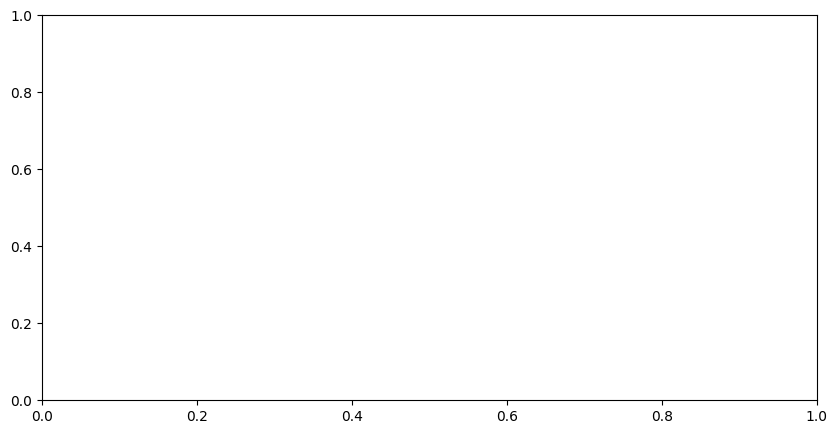

In [79]:
root_dir = "dataset/"

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

data = create_datasets(root_dir = "dataset/", batch_size=8)
train_loader = data["train"]
val_loader = data["val"]
test_loader = data["test"]

# Create model and move to device
model = NvidiaPaperNetwork().to(device)

# Print model summary
print(model)

# Count number of parameters
total_params = sum(p.numel() for p in model.parameters())
print(f"Total parameters: {total_params:,}")

# Train the model
best_model_path = training(model, train_loader, test_loader, device, epochs=70)

# Load the best model
model.load_state_dict(torch.load(best_model_path))


In [80]:
# Evaluate the model
evaluate_model(model, test_loader, device)

Evaluating: 100%|██████████| 5/5 [00:00<00:00, 25.64it/s, loss=1.49] 

Final test loss: 0.918964
Mean Absolute Error: 0.18581345677375793


(0.9189636707305908, np.float32(0.18581346))

## Exporting the model

In [81]:
model.eval()

import torch

# Assuming your model takes a (3, 224, 224) image as input
dummy_input = torch.randn(1, 3, 224, 224).to(device)  # Batch size of 1

import torch.onnx

# Path where the ONNX model will be saved
onnx_model_path = "model_jetbot.onnx"

# Exporting the model
torch.onnx.export(
    model,               # Model to export
    dummy_input,         # Example input tensor
    onnx_model_path,     # Path to save the ONNX file
    opset_version=11,    # Define the ONNX opset version
    input_names=["input"],       # Name of the input node
    output_names=["output"],     # Name of the output node
    dynamic_axes={
        "input": {0: "batch_size"},  # Dynamic batch size
        "output": {0: "batch_size"}  # Dynamic batch size
    },
    do_constant_folding=True,  # Enable constant folding optimization
    # verbose=True              # Show detailed export info
)

import onnx

# Load the exported model
onnx_model = onnx.load(onnx_model_path)

# Check if the model is valid
onnx.checker.check_model(onnx_model)

print("Model has been successfully exported to ONNX format!")



Model has been successfully exported to ONNX format!
